Import the library to process

In [1]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img
import numpy as np
import cv2, os
from tensorflow.keras.models import load_model
from tensorflow.keras.optimizers import RMSprop,Adam,SGD
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from matplotlib import pyplot as plt
from imutils import paths
import tensorflow as tf
import pandas as pd
import seaborn as sns
from sklearn.utils import shuffle

2023-11-01 15:30:29.485639: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-11-01 15:30:29.487233: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-11-01 15:30:29.520914: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-11-01 15:30:29.520939: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-11-01 15:30:29.520955: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to regi

In [2]:
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [3]:
image_size = 224
data_path = "fire_dataset/"

Stage 02: Data Preprocessing \
This stage convert the images are selected in disk, performing various stage such as resize image, one hot encoding on labels, convert image size

In [4]:
#Take list of train image
train_image_path = list(paths.list_images(data_path + "train"))
#Take list of val image
val_image_path = list(paths.list_images(data_path + "test"))
#Make list of class: wear_mask and unwear_mask
classNames = np.array(sorted(os.listdir(data_path + "train")))
#Build function to process images
def preprocess_image(image_path):
  image = tf.io.read_file(image_path)
  image = tf.image.decode_image(image,channels=3,expand_animations=False)
  image = tf.image.resize(image,(image_size,image_size))
  image = image / 255.0

  label = tf.strings.split(image_path,os.path.sep)[-2]
  oneHot = label == classNames
  encodedLabel = tf.argmax(oneHot)

  return (image,encodedLabel)

In [5]:
#Using Tf.data to create pipeline load and process image
train_dataset = tf.data.Dataset.from_tensor_slices(train_image_path)
train_dataset = (train_dataset
                 .map(preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
                 .batch(64)
                 .prefetch(tf.data.AUTOTUNE)
                 )
val_dataset = tf.data.Dataset.from_tensor_slices(val_image_path)
val_dataset = (val_dataset
                 .map(preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
                 .batch(64)
                 .prefetch(tf.data.AUTOTUNE)
                 )

2023-11-01 15:30:31.458849: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-11-01 15:30:31.459125: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2211] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [6]:
img_fires = []
labels_fires = []
fire_path = data_path + "train/" + "fire_images/"
nonFire_path = data_path + "train/" + "non_fire_images/"
for i in os.listdir(fire_path):
  img = os.path.join(fire_path + "/" ,i)
  img_fires.append(img)
  labels_fires.append("fire")
img_no_fires = []
target_no_fires = []
for i in os.listdir(nonFire_path):
  img = os.path.join(nonFire_path + "/" ,i)
  img_no_fires.append(img)
  target_no_fires.append("non fire")
fire_df = pd.DataFrame()
fire_df["image"] = img_fires
fire_df["target"] = labels_fires
no_fires_df = pd.DataFrame()
no_fires_df["image"] = img_no_fires
no_fires_df["target"] = target_no_fires
df = pd.concat([fire_df, no_fires_df], axis = 0,ignore_index = True)
df = shuffle(df)
df

,image,target
797,fire_dataset/train/fire_images//fire.447.png,fire
685,fire_dataset/train/fire_images//fire.346.png,fire
1350,fire_dataset/train/non_fire_images//non_fire.2...,non fire
321,fire_dataset/train/fire_images//000357.jpg,fire
959,fire_dataset/train/fire_images//fire.593.png,fire
...,...,...
754,fire_dataset/train/fire_images//fire.408.png,fire
501,fire_dataset/train/fire_images//fire.180.png,fire
1297,fire_dataset/train/non_fire_images//non_fire.1...,non fire
88,fire_dataset/train/fire_images//000090.jpg,fire


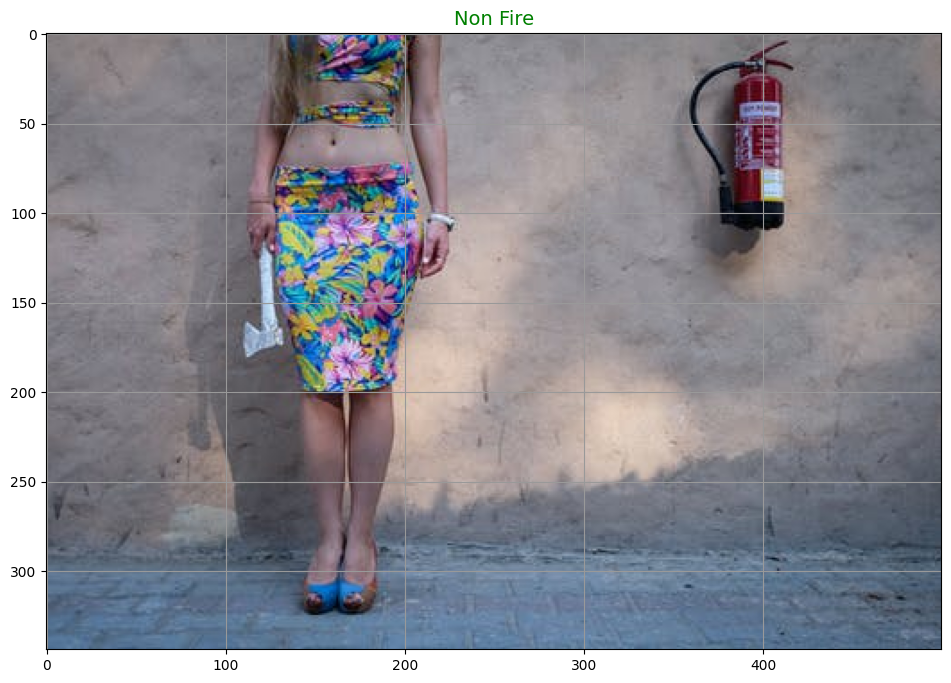

In [7]:
plt.figure(figsize = (12,8))
img = load_img(no_fires_df["image"][10])
plt.imshow(img)
plt.title("Non Fire",color="green",size = 14)
plt.grid(color='#999999',linestyle='-')
plt.show()

In [8]:
x_train = df.iloc[0:10000, ]
x_val = df.iloc[10001:11001, ]
x_test = df.iloc[11002:, ]

In [9]:
print("Train Seti:","\n",x_train["target"].value_counts(),"\n""Validation Seti: ","\n", x_val["target"].value_counts(), "\n"
      "Test Seti: ", "\n",x_test["target"].value_counts())

Train Seti: 
 target
fire        1167
non fire     275
Name: count, dtype: int64 
Validation Seti:  
 Series([], Name: count, dtype: int64) 
Test Seti:  
 Series([], Name: count, dtype: int64)


In [10]:
checkpoint = ModelCheckpoint("model.h5",monitor='val_acc',verbose = 1,save_best_only=True,mode='max')

In [11]:
model = load_model("model.h5")

In [12]:
# model.load_weights("model_emotion.h5")

In [13]:
#Training model
history = model.fit(
    train_dataset,
    steps_per_epoch= len(train_dataset),
    epochs = 50,
    validation_data = val_dataset,
    validation_steps = len(val_dataset),
    verbose = 1
)

Epoch 1/50
23/23 [==============================] - 33s 1s/step - loss: 0.5890 - accuracy: 0.9126 - val_loss: 3.2404 - val_accuracy: 0.2442
Epoch 2/50
23/23 [==============================] - 31s 1s/step - loss: 0.3894 - accuracy: 0.8981 - val_loss: 2.3746 - val_accuracy: 0.2442
Epoch 3/50
23/23 [==============================] - 33s 1s/step - loss: 0.2637 - accuracy: 0.9202 - val_loss: 2.0135 - val_accuracy: 0.2442
Epoch 4/50
23/23 [==============================] - 32s 1s/step - loss: 0.1766 - accuracy: 0.9348 - val_loss: 1.9177 - val_accuracy: 0.2533
Epoch 5/50
23/23 [==============================] - 32s 1s/step - loss: 0.1350 - accuracy: 0.9480 - val_loss: 1.8435 - val_accuracy: 0.2863
Epoch 6/50
23/23 [==============================] - 32s 1s/step - loss: 0.0879 - accuracy: 0.9598 - val_loss: 1.5652 - val_accuracy: 0.3974
Epoch 7/50
23/23 [==============================] - 31s 1s/step - loss: 0.0518 - accuracy: 0.9771 - val_loss: 1.3063 - val_accuracy: 0.4995
Epoch 8/50
23/23 [==

In [14]:
model.save_weights('model_emotion.h5')
print("Saved Successful")

Saved Successful


Text(0.5, 1.0, 'Training and validation loss')

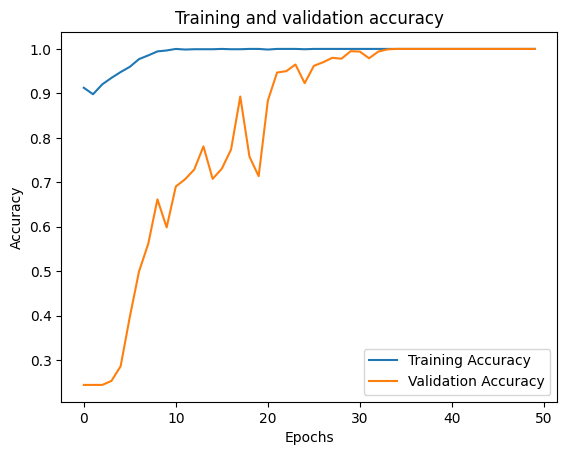

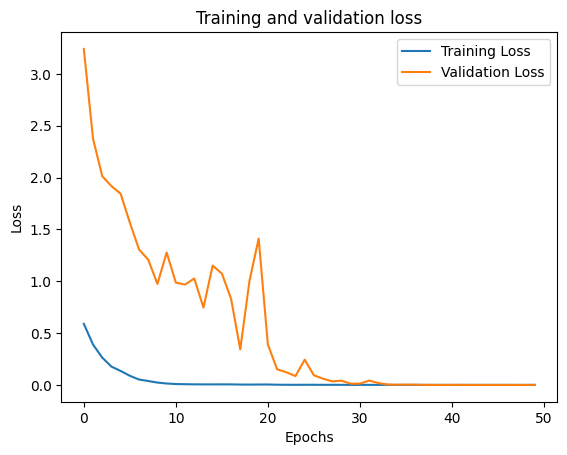

In [15]:
acc      = history.history[     'accuracy' ]
val_acc  = history.history[ 'val_accuracy' ]
loss     = history.history[    'loss' ]
val_loss = history.history['val_loss' ]

epochs   = range(len(acc))

plt.figure(1)
plt.plot  ( epochs,     acc )
plt.plot  ( epochs, val_acc )
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend( ["Training Accuracy", "Validation Accuracy"])
plt.title ('Training and validation accuracy')
plt.figure(2)
plt.plot  ( epochs,     loss )
plt.plot  ( epochs, val_loss )
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend( ["Training Loss", "Validation Loss"])
plt.title ('Training and validation loss'   )

Plot Confusion Matrix - Examine Accuracy, loss of model are trained

In [16]:
train_dir = data_path + 'train'
val_dir = data_path + 'test'
train_datagen = ImageDataGenerator(rescale=1./255)
train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(48,48),
        batch_size=64,
        color_mode="grayscale",
        class_mode='categorical')
val_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = val_datagen.flow_from_directory(
        val_dir,
        target_size=(48,48),
        batch_size=64,
        color_mode="grayscale",
        class_mode='categorical')

Found 1442 images belonging to 2 classes.
Found 999 images belonging to 2 classes.


In [17]:
%matplotlib inline
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score
import itertools

In [18]:
def plot_confusion_matrix(cm,classes,normalize=False,title='Confusion Matrix',cmap=plt.cm.Blues):
  plt.imshow(cm,interpolation='nearest',cmap=cmap)
  plt.title(title)
  plt.colorbar()
  tick_marks = np.arange(len(classes))
  plt.xticks(tick_marks,classes,rotation=45)
  plt.yticks(tick_marks,classes)

  if normalize:
    cm = cm.astype('float') / cm.sum(axis = 1)[:,np.newaxis]
    print("Normalized confusion matrix")
  else:
    print("Confusion matrix, without normalization")
  print(cm)

  thresh = cm.max() / 2
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j,i, cm[i,j],horizontalalignment="center",color="white" if cm[i,j] > thresh else "black")

In [19]:
y_pred = model.predict(val_dataset,verbose=0)
predict = []
for i in range(len(y_pred)):
  if y_pred[i][0] > 0.5:
    predict.append(1)
  else:
    predict.append(0)

In [20]:
x_pred = model.predict(train_dataset,verbose=0)
predict_train = []
for i in range(len(x_pred)):
  if x_pred[i][0] > 0.5:
    predict_train.append(1)
  else:
    predict_train.append(0)

In [21]:
cm = confusion_matrix(validation_generator.classes,predict)

Confusion matrix, without normalization
[[755   0]
 [  0 244]]


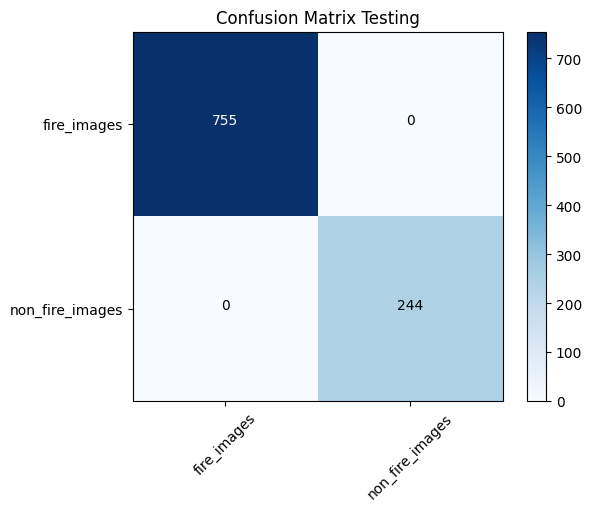

In [22]:
plot_confusion_matrix(cm = cm,classes=classNames,title='Confusion Matrix Testing')

In [23]:
cm_train = confusion_matrix(train_generator.classes,predict_train)

Confusion matrix, without normalization
[[1167    0]
 [   0  275]]


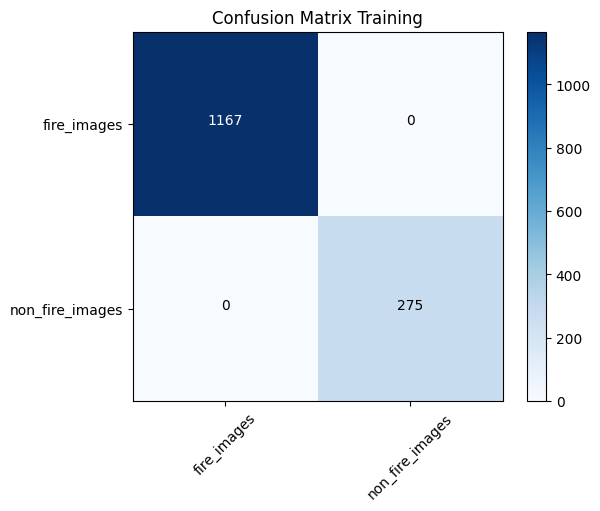

In [24]:
plot_confusion_matrix(cm = cm_train, classes=classNames,title='Confusion Matrix Training')